In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_FOLDER = 'results/' # use empty string if none

AUX_FOLDER = DATA_FOLDER + 'auxiliary/' # use empty if none

In [3]:
fn_main = [
    DATA_FOLDER + 'results.json',
    DATA_FOLDER + 'results_deterministic.json',
    DATA_FOLDER + 'results_graph.json',
    DATA_FOLDER + 'results_small_eps.json',
    ]

In [4]:
fn_aux_1 = [
    AUX_FOLDER + 'results_semisparse_64.json',
    AUX_FOLDER + 'results_semisparse_256.json',
    AUX_FOLDER + 'results_semisparse_1024.json',
    ]

In [5]:
fn_aux_2 = [
    AUX_FOLDER + 'results_dense_128_128_1.json',
    AUX_FOLDER + 'results_dense_128_256_1.json',
    AUX_FOLDER + 'results_dense_256_128_1.json',
    AUX_FOLDER + 'results_dense_256_256_1.json',
    AUX_FOLDER + 'results_dense_128_128_2.json',
    AUX_FOLDER + 'results_dense_128_256_2.json',
    AUX_FOLDER + 'results_dense_256_128_2.json',
    AUX_FOLDER + 'results_dense_256_256_2.json',
]

In [6]:
# all filenames
fn = fn_main + fn_aux_1 + fn_aux_2

In [7]:
data_dic = {} # all json dumps, per fn
for f in fn:
    with open(f, 'r') as f:
        fn_json = json.load(f)
        data_dic.update({f.name:fn_json})

In [8]:
# graphical parameteres

plt.rcParams["figure.figsize"] = (13,7)
markers = ['o','+','*','s','d','v','>','h']

In [9]:
def extract_mean_round_num_from_group(group_res):
    round_count = {'cpu':[],'gpu':[]}
    for iters_res in group_res:
        for iter in iters_res['iteration_res']:
            round_count[iter['device']].append(iter['auction_rounds'])
    res = {'cpu':{'mean':0,'sd':0}, 'gpu':{'mean':0,'sd':0},}

    for dev in ['cpu', 'gpu']:
        try:
            mean = sum(round_count[dev])/len(round_count[dev])
            aux = [(el-mean)**2 for el in round_count[dev]]
            sd = (sum(aux)/(len(aux)-1))**(0.5)
        except Exception as e:
            mean = 0
            sd = 0
        res[dev]['mean'] = mean
        res[dev]['sd'] = sd

    return res


In [11]:

def filter_tiemout(el, arglist):
    if not (el['group_values']['output'].startswith('timeout')):
        output = el
        for arg in arglist:
            output = output[arg]
            
        return output
    return None



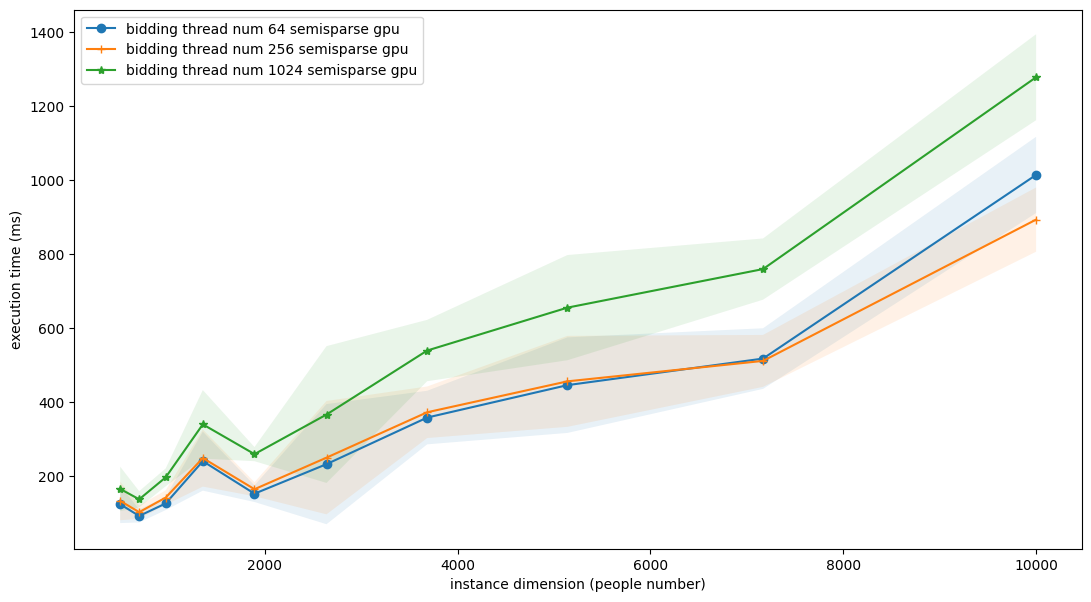

In [12]:
## semisparse 1

j=0
plt.figure()

results = pd.DataFrame()

for case,data in data_dic.items():
    if case not in fn_aux_1:
        continue
    directories = [el['directory'] for el in  data]
    for i in range(len(directories)): # dense and sparse
        #print(data[i]['directory_results'][-1])

        round_number = [extract_mean_round_num_from_group(out['group_values']['partitioned_output']['group_results'])['gpu'] for out in  data[i]['directory_results']]
        obj_number = [el['obj_number'] for el in data[i]['directory_results']]
        gpu_mean_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_mean']) for el in data[i]['directory_results']])))
        gpu_sd_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_sd']) for el in data[i]['directory_results']])))
        person_number = [el['person_number'] for el in data[i]['directory_results']][:len(gpu_mean_times)]
        plt.plot(person_number, gpu_mean_times, '-'+markers[j], label='bidding thread num ' + ' '.join(case.split('_')[-1:]).split('.')[0] + ' ' +directories[i].split('/')[1] + ' gpu')
        plt.fill_between(person_number,gpu_mean_times-gpu_sd_times,gpu_mean_times+gpu_sd_times,alpha=.1)
        plt.legend(loc="upper left")
        plt.xlabel("instance dimension (people number)")
        plt.ylabel("execution time (ms)")
        j+=1
        results[case+'_mean_exec_time'] = gpu_mean_times
        results[case+'_sd_exec_time'] = gpu_sd_times
        results[case+'_mean_round_num'] = [el['mean'] for el in round_number]
        results[case+'_sd_round_num'] =  [el['sd'] for el in round_number]
    results.index = person_number



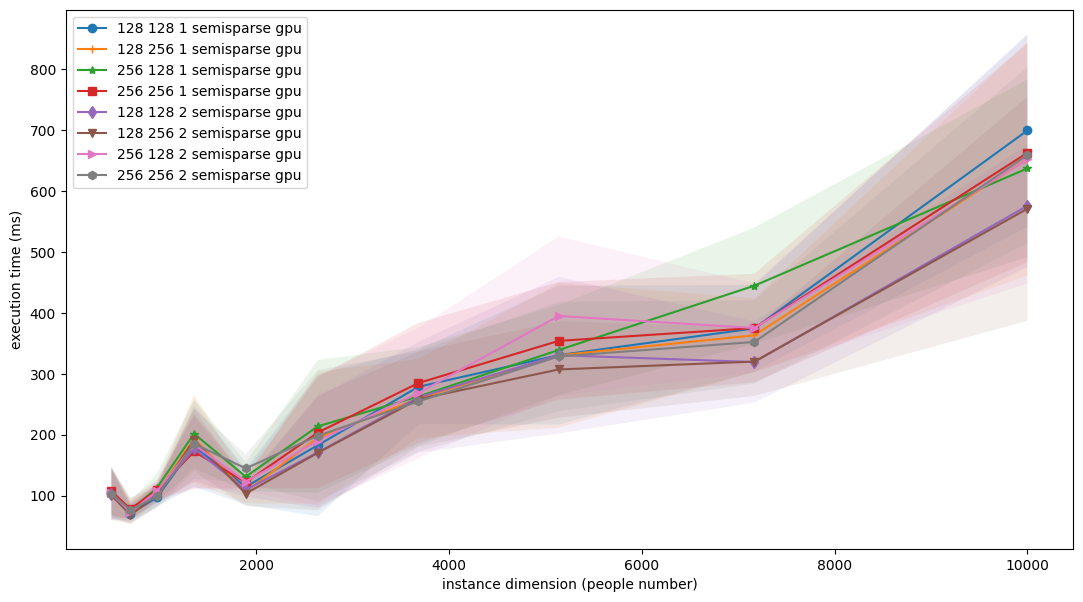

In [13]:
## semisparse 2

j=0
plt.figure()

results = pd.DataFrame()

for case,data in data_dic.items():
    if case not in fn_aux_2:
        continue
    directories = [el['directory'] for el in  data]
    for i in range(len(directories)): # dense and sparse
        #print(data[i]['directory_results'][-1])

        round_number = [extract_mean_round_num_from_group(out['group_values']['partitioned_output']['group_results'])['gpu'] for out in  data[i]['directory_results']]
        obj_number = [el['obj_number'] for el in data[i]['directory_results']]
        gpu_mean_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_mean']) for el in data[i]['directory_results']])))
        gpu_sd_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_sd']) for el in data[i]['directory_results']])))
        person_number = [el['person_number'] for el in data[i]['directory_results']][:len(gpu_mean_times)]
        plt.plot(person_number, gpu_mean_times, '-'+markers[j], label=' '.join(case.split('_')[-3:]).split('.')[0] + ' ' +directories[i].split('/')[1] + ' gpu')
        plt.fill_between(person_number,gpu_mean_times-gpu_sd_times,gpu_mean_times+gpu_sd_times,alpha=.1)
        plt.legend(loc="upper left")
        plt.xlabel("instance dimension (people number)")
        plt.ylabel("execution time (ms)")
        j+=1
        results[case+'_mean_exec_time'] = gpu_mean_times
        results[case+'_sd_exec_time'] = gpu_sd_times
        results[case+'_mean_round_num'] = [el['mean'] for el in round_number]
        results[case+'_sd_round_num'] =  [el['sd'] for el in round_number]
    results.index = person_number



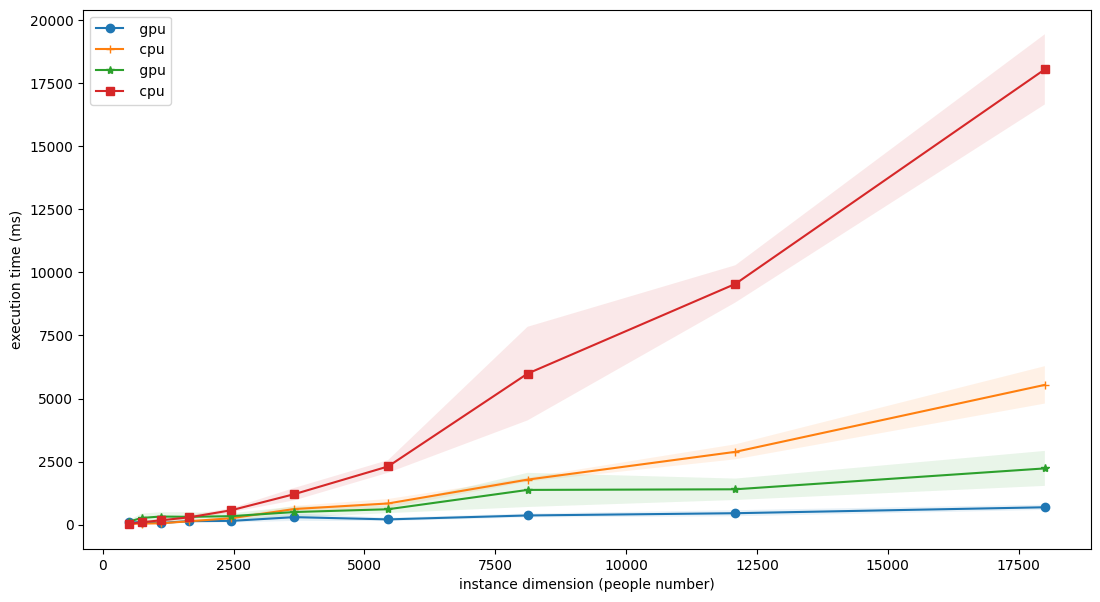

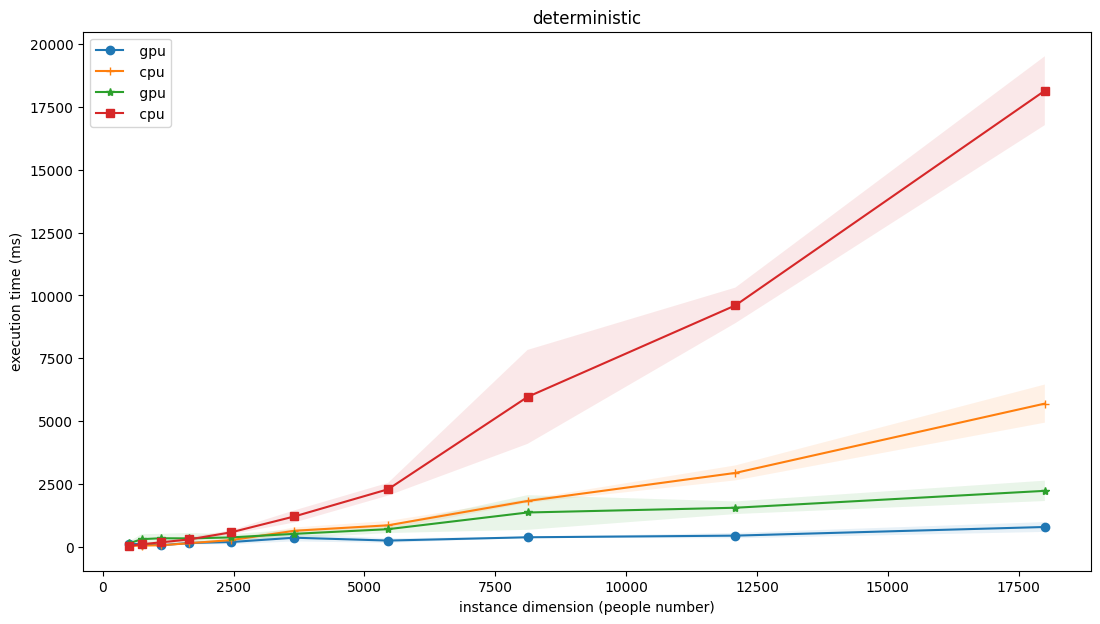

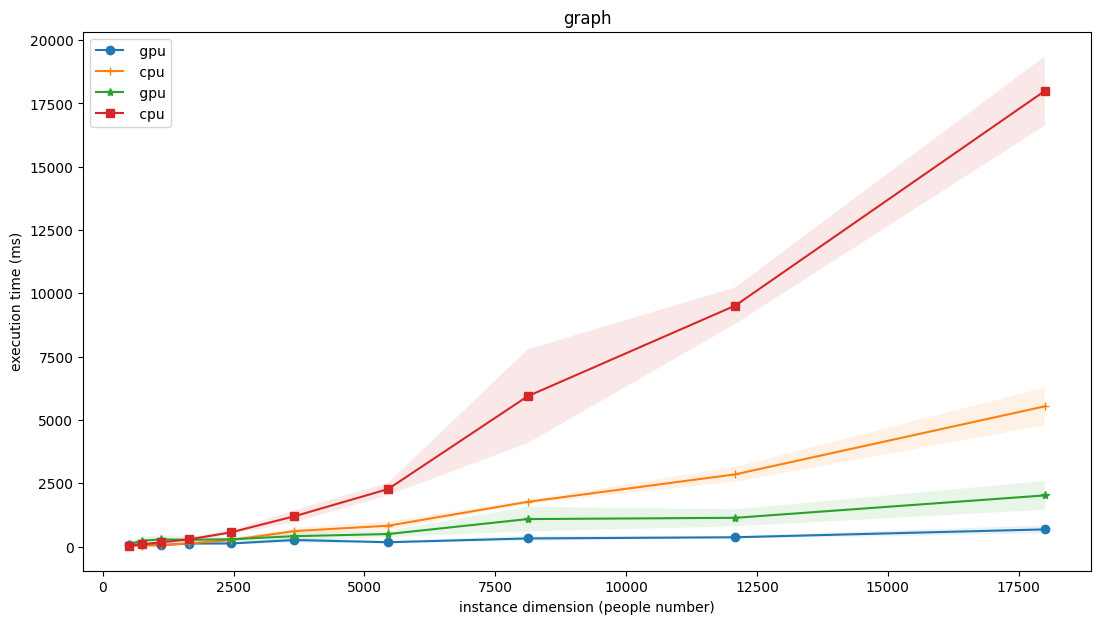

In [14]:
total_res = []
for case,data in data_dic.items():
    #print(case)
    if case in fn_main and not case.split('.')[0].endswith('eps'):
        directories = [el['directory'] for el in  data]
        plt.figure()
        plt.title((' '.join(case.split('/')[-1].split('_')[1:]).split('.')[0]))
        result_list = []
        j = 0
        for i in range(len(directories)): # dense and sparse
            results = pd.DataFrame()
            round_number = [extract_mean_round_num_from_group(out['group_values']['partitioned_output']['group_results'])['gpu'] for out in  data[i]['directory_results']]
            cpu_round_number = [extract_mean_round_num_from_group(out['group_values']['partitioned_output']['group_results'])['cpu'] for out in  data[i]['directory_results']]
            person_number = [el['person_number'] for el in data[i]['directory_results']]
            obj_number = [el['obj_number'] for el in data[i]['directory_results']]
            gpu_mean_times = np.array( [el['group_values']['times']['gpu_time_mean'] for el in data[i]['directory_results']])
            gpu_sd_times = np.array( [el['group_values']['times']['gpu_time_sd'] for el in data[i]['directory_results']])
            cpu_mean_times = np.array( [el['group_values']['times']['cpu_time_mean'] for el in data[i]['directory_results']])
            cpu_sd_times = np.array( [el['group_values']['times']['cpu_time_sd'] for el in data[i]['directory_results']])
            plt.plot(person_number, gpu_mean_times, '-'+markers[j], label=directories[i].split('/')[-1]+ ' gpu')
            plt.fill_between(person_number,gpu_mean_times-gpu_sd_times,gpu_mean_times+gpu_sd_times,alpha=.1)
            j +=1
            plt.plot(person_number, cpu_mean_times, '-'+markers[j], label=directories[i].split('/')[-1] + ' cpu')
            plt.fill_between(person_number,cpu_mean_times-cpu_sd_times,cpu_mean_times+cpu_sd_times,alpha=.1)
            j +=1
            plt.legend(loc="upper left")
            plt.xlabel("instance dimension (people number)")
            plt.ylabel("execution time (ms)")
            
            results[case+'_gpu_mean_exec_time'] = gpu_mean_times
            results[case+'_gpu_sd_exec_time'] = gpu_sd_times
            results[case+'_mean_round_num'] = [el['mean'] for el in round_number]
            results[case+'_sd_round_num'] =  [el['sd'] for el in round_number]
            
            results[case+'_cpu_mean_exec_time'] = cpu_mean_times
            results[case+'_cpu_sd_exec_time'] = cpu_sd_times
            results[case+'_cpu_mean_round_num'] = [el['mean'] for el in cpu_round_number]
            results[case+'_cpu_sd_round_num'] =  [el['sd'] for el in cpu_round_number]
            results.index = person_number
            result_list.append(results)
        total_res.append(result_list)
    

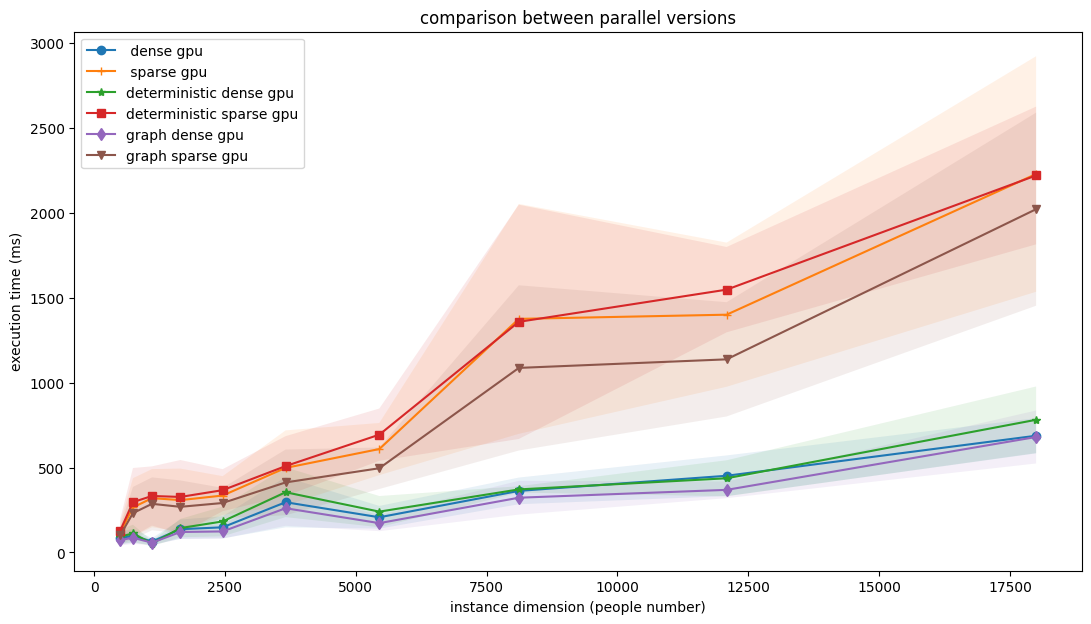

In [15]:
plt.figure()
j = 0
plt.title("comparison between parallel versions")
for case,data in data_dic.items():
    if case in fn_main and not case.split('.')[0].endswith('eps'):
        directories = [el['directory'] for el in  data]
        for i in range(len(directories)): # dense and sparse
            person_number = [el['person_number'] for el in data[i]['directory_results']]
            obj_number = [el['obj_number'] for el in data[i]['directory_results']]
            gpu_mean_times = np.array( [el['group_values']['times']['gpu_time_mean'] for el in data[i]['directory_results']])
            gpu_sd_times = np.array( [el['group_values']['times']['gpu_time_sd'] for el in data[i]['directory_results']])
            cpu_mean_times = np.array( [el['group_values']['times']['cpu_time_mean'] for el in data[i]['directory_results']])
            cpu_sd_times = np.array( [el['group_values']['times']['cpu_time_sd'] for el in data[i]['directory_results']])
            plt.plot(person_number, gpu_mean_times, '-'+markers[j], label=' '.join(case.split('/')[-1].split('_')[1:]).split('.')[0] + ' ' +directories[i].split('/')[1] + ' gpu')
            plt.fill_between(person_number,gpu_mean_times-gpu_sd_times,gpu_mean_times+gpu_sd_times,alpha=.1)
            plt.legend(loc="upper left")
            plt.xlabel("instance dimension (people number)")
            plt.ylabel("execution time (ms)")
            j+=1

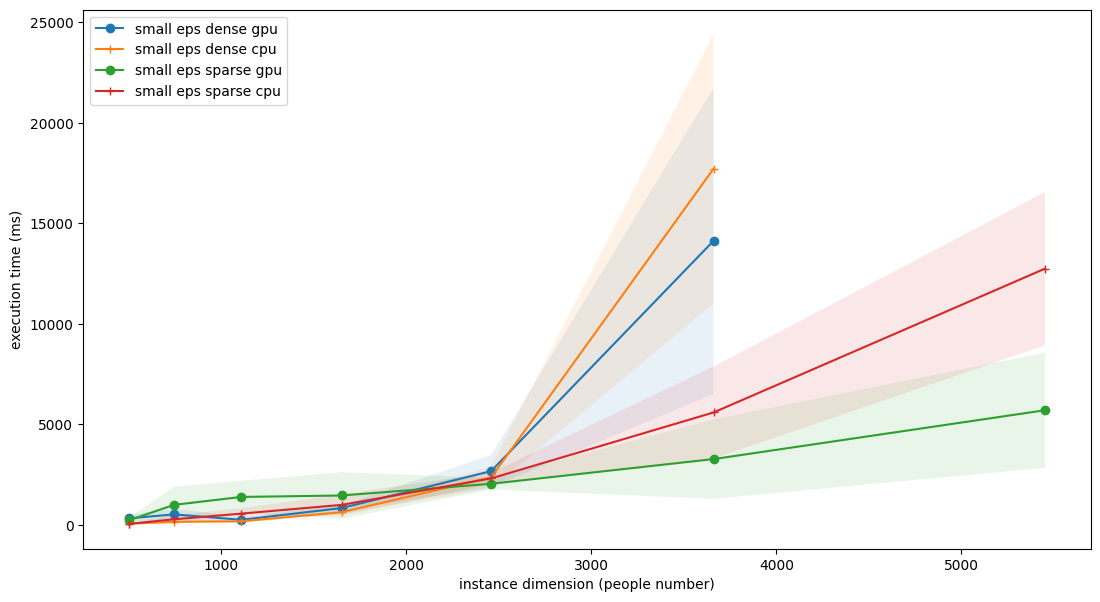

In [16]:
j=0
for case,data in data_dic.items():
    if case.split('.')[0].endswith('eps'):
        directories = [el['directory'] for el in  data]
        plt.figure()
        result_small_eps_list = []
        for i in range(len(directories)): # dense and sparse
            results = pd.DataFrame()
            j = 0

            round_number = [extract_mean_round_num_from_group(out)['gpu'] for out in list(filter(None, [filter_tiemout(el,['group_values','partitioned_output','group_results']) for el in data[i]['directory_results']]))]
            cpu_round_number = [extract_mean_round_num_from_group(out)['cpu'] for out in list(filter(None, [filter_tiemout(el,['group_values','partitioned_output','group_results']) for el in data[i]['directory_results']]))]

    
            #print(data[i]['directory_results'][-1])
            obj_number = [el['obj_number'] for el in data[i]['directory_results']]
            gpu_mean_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_mean']) for el in data[i]['directory_results']])))
            gpu_sd_times = np.array( list(filter(None, [filter_tiemout(el,['group_values','times','gpu_time_sd']) for el in data[i]['directory_results']])))
            cpu_mean_times = np.array(list(filter(None,  [filter_tiemout(el,['group_values','times','cpu_time_mean']) for el in data[i]['directory_results']])))
            cpu_sd_times = np.array(list(filter(None,  [filter_tiemout(el,['group_values','times','cpu_time_sd']) for el in data[i]['directory_results']])))
            person_number = [el['person_number'] for el in data[i]['directory_results']][:len(gpu_mean_times)]
            plt.plot(person_number, gpu_mean_times, '-'+markers[j], label=' '.join(case.split('_')[-2:]).split('.')[0] + ' ' +directories[i].split('/')[1] + ' gpu')
            plt.fill_between(person_number,gpu_mean_times-gpu_sd_times,gpu_mean_times+gpu_sd_times,alpha=.1)
            j+=1
            plt.plot(person_number, cpu_mean_times, '-'+markers[j],label=' '.join(case.split('_')[-2:]).split('.')[0]+ ' ' +directories[i].split('/')[1] + ' cpu')
            plt.fill_between(person_number,cpu_mean_times-cpu_sd_times,cpu_mean_times+cpu_sd_times,alpha=.1)
            plt.xlabel("instance dimension (people number)")
            plt.ylabel("execution time (ms)")
            plt.legend(loc="upper left")
            j+=1

            results[case+'_gpu_mean_exec_time'] = gpu_mean_times
            results[case+'_gpu_sd_exec_time'] = gpu_sd_times
            results[case+'_mean_round_num'] = [el['mean'] for el in round_number]
            results[case+'_sd_round_num'] =  [el['sd'] for el in round_number]
            #if i == 0:
            results[case+'_cpu_mean_exec_time'] = cpu_mean_times
            results[case+'_cpu_sd_exec_time'] = cpu_sd_times
            results[case+'_cpu_mean_round_num'] = [el['mean'] for el in cpu_round_number]
            results[case+'_cpu_sd_round_num'] =  [el['sd'] for el in cpu_round_number]
            results.index = person_number
            result_small_eps_list.append(results)

In [17]:
case_names = ['dense ', 'sparse ']
exec_names = ['', 'det. ', 'graph ']

out_round_num = pd.DataFrame()
out_times = pd.DataFrame()

for i,exec in enumerate(total_res):
    for j,case in enumerate(exec):
        case_prefix = exec_names[i] + case_names[j]
        colnames = ['gpu_mean', 'gpu_sd', "gpu_round_num_mean", "gpu_round_num_sd",'cpu_mean', 'cpu_sd', "cpu_round_num_mean", "cpu_round_num_sd"]
        aux_round_num = pd.DataFrame(case)
        aux_times = pd.DataFrame(case)
        aux_round_num.columns = colnames
        aux_times.columns = colnames

        mean = aux_times['gpu_mean'].apply(lambda x: "{:.2f}".format(x))
        sd = aux_times['gpu_sd'].apply(lambda x: " ({:.2f})".format(x))
        out_times[case_prefix + 'gpu exec time (ms)'] = mean+sd

        mean = aux_round_num['gpu_round_num_mean'].apply(lambda x: "{:.2f}".format(x))
        sd = aux_round_num['gpu_round_num_sd'].apply(lambda x: " ({:.2f})".format(x))
        out_round_num[case_prefix + 'gpu round num'] = mean+sd

        if i == 0:
            mean = aux_times['cpu_mean'].apply(lambda x: "{:.2f}".format(x))
            sd = aux_times['cpu_sd'].apply(lambda x: " ({:.2f})".format(x))
            out_times[case_prefix + 'cpu exec time (ms)'] = mean+sd

            mean = aux_round_num['cpu_round_num_mean'].apply(lambda x: "{:.2f}".format(x))
            sd = aux_round_num['cpu_round_num_sd'].apply(lambda x: " ({:.2f})".format(x))
            out_round_num[case_prefix + 'cpu round num'] = mean+sd

In [18]:
exec_names = 'small eps. '
case_names = ['dense ','sparse ']
for j,case in enumerate(result_small_eps_list):
    case_prefix = exec_names + case_names[j]
    colnames = ['gpu_mean', 'gpu_sd', "gpu_round_num_mean", "gpu_round_num_sd",'cpu_mean', 'cpu_sd', "cpu_round_num_mean", "cpu_round_num_sd"]
    aux_round_num = pd.DataFrame(case)
    aux_times = pd.DataFrame(case)
    aux_round_num.columns = colnames
    aux_times.columns = colnames
    
    mean = aux_times['gpu_mean'].apply(lambda x: "{:.2f}".format(x))
    sd = aux_times['gpu_sd'].apply(lambda x: " ({:.2f})".format(x))
    out_times[case_prefix + 'gpu exec time (ms)'] = mean+sd

    mean = aux_round_num['gpu_round_num_mean'].apply(lambda x: "{:.2f}".format(x))
    sd = aux_round_num['gpu_round_num_sd'].apply(lambda x: " ({:.2f})".format(x))
    out_round_num[case_prefix + 'gpu round num'] = mean+sd

    mean = aux_times['cpu_mean'].apply(lambda x: "{:.2f}".format(x))
    sd = aux_times['cpu_sd'].apply(lambda x: " ({:.2f})".format(x))
    out_times[case_prefix + 'cpu exec time (ms)'] = mean+sd

    mean = aux_round_num['cpu_round_num_mean'].apply(lambda x: "{:.2f}".format(x))
    sd = aux_round_num['cpu_round_num_sd'].apply(lambda x: " ({:.2f})".format(x))
    out_round_num[case_prefix + 'cpu round num'] = mean+sd



In [19]:
out_round_num.to_csv('resultsRoundNum.csv')
out_times.to_csv('resultsTimes.csv')


In [20]:
out_round_num

,dense gpu round num,dense cpu round num,sparse gpu round num,sparse cpu round num,det. dense gpu round num,det. sparse gpu round num,graph dense gpu round num,graph sparse gpu round num,small eps. dense gpu round num,small eps. dense cpu round num,small eps. sparse gpu round num,small eps. sparse cpu round num
500,3176.87 (1558.82),3071.33 (1552.49),4372.33 (2552.93),4364.33 (2557.94),3071.33 (1552.49),4364.33 (2557.94),3163.73 (1526.89),4372.33 (2552.93),12983.27 (7189.66),12974.00 (7424.21),8825.00 (5829.74),8773.67 (5866.24)
744,3507.33 (1662.54),3737.00 (1873.35),9935.13 (7039.40),9940.67 (7189.57),3737.00 (1873.35),9940.67 (7189.57),3571.80 (1682.33),9922.07 (7091.79),19938.93 (11491.31),19108.33 (11107.58),39266.60 (37265.98),39119.33 (37047.20)
1108,1979.93 (714.35),1377.67 (526.72),11520.53 (6794.83),11397.33 (6637.62),1377.67 (526.72),11397.33 (6637.62),2027.13 (593.52),11580.00 (6869.16),8743.67 (5668.91),8699.33 (5798.44),50844.73 (30931.16),50865.00 (30892.46)
1650,4425.67 (2154.68),4353.00 (1932.48),10452.33 (7188.58),10308.00 (7801.87),4353.00 (1932.48),10308.00 (7801.87),4487.33 (1763.11),10528.87 (6859.08),30853.53 (5291.65),32172.33 (5270.22),51902.67 (44364.14),51202.67 (43619.23)
2458,4256.67 (2373.14),5170.33 (3090.82),10241.33 (4299.81),10676.33 (4504.33),5170.33 (3090.82),10676.33 (4504.33),4168.73 (1843.62),10541.07 (4061.93),98341.80 (30987.04),99424.00 (31197.76),71565.07 (11296.83),69787.33 (10297.77)
3660,8935.07 (5543.74),10066.67 (4992.63),14965.73 (8134.88),13846.33 (5763.02),10066.67 (4992.63),13846.33 (5763.02),9234.07 (4502.62),14501.40 (8401.92),497157.07 (288563.89),502452.33 (292669.05),110249.27 (72795.18),106652.00 (65676.08)
5451,4465.53 (2148.99),5199.33 (2910.33),15995.80 (5355.98),17505.33 (5076.97),5199.33 (2910.33),17505.33 (5076.97),4374.47 (2003.38),15702.53 (5367.41),NaN,NaN,177905.27 (96852.25),178896.00 (95227.85)
8117,7676.47 (2541.58),7244.33 (543.67),37770.93 (22505.28),35732.33 (22439.67),7244.33 (543.67),35732.33 (22439.67),8457.73 (4305.18),36962.40 (21007.62),NaN,NaN,NaN,NaN
12087,7030.67 (3883.93),5592.33 (3142.12),32082.73 (13655.47),33686.33 (7832.03),5592.33 (3142.12),33686.33 (7832.03),5680.53 (1954.80),30132.13 (14260.18),NaN,NaN,NaN,NaN
18000,7145.13 (2837.96),8186.00 (4972.83),41501.73 (19470.77),37676.67 (10612.75),8186.00 (4972.83),37676.67 (10612.75),8258.53 (4945.32),42904.80 (18815.52),NaN,NaN,NaN,NaN


In [21]:
out_times

,dense gpu exec time (ms),dense cpu exec time (ms),sparse gpu exec time (ms),sparse cpu exec time (ms),det. dense gpu exec time (ms),det. sparse gpu exec time (ms),graph dense gpu exec time (ms),graph sparse gpu exec time (ms),small eps. dense gpu exec time (ms),small eps. dense cpu exec time (ms),small eps. sparse gpu exec time (ms),small eps. sparse cpu exec time (ms)
500,85.00 (37.54),20.65 (5.34),117.37 (58.07),31.48 (6.26),92.94 (42.71),128.68 (67.40),73.74 (32.33),101.06 (51.33),332.91 (170.34),67.15 (25.50),235.50 (137.29),53.56 (15.53)
744,97.97 (41.19),40.67 (9.58),265.52 (172.16),93.99 (40.66),112.45 (50.99),296.72 (200.90),86.62 (36.46),231.96 (154.01),526.87 (284.19),155.06 (55.82),1001.40 (896.04),283.08 (204.67)
1108,64.73 (19.74),51.04 (11.59),320.12 (171.10),169.61 (57.40),52.81 (15.88),332.83 (174.42),57.80 (14.00),286.57 (155.68),256.91 (150.48),185.28 (89.25),1395.63 (804.18),565.46 (263.96)
1650,137.25 (56.77),132.21 (26.90),308.50 (185.74),288.21 (97.78),143.84 (54.01),327.17 (217.55),120.71 (40.80),269.00 (155.25),842.73 (137.65),635.01 (76.98),1467.23 (1161.82),1000.44 (528.70)
2458,148.29 (65.22),254.13 (60.48),335.39 (114.21),571.08 (78.00),182.95 (87.58),367.07 (123.70),124.06 (42.32),291.47 (89.15),2681.10 (796.02),2367.75 (561.92),2049.85 (286.46),2317.74 (280.92)
3660,296.05 (148.00),618.13 (124.18),498.15 (220.84),1208.28 (245.63),354.84 (146.66),508.78 (176.32),260.63 (103.46),412.66 (193.53),14135.33 (7620.05),17722.16 (6690.81),3278.19 (1973.56),5596.85 (2286.47)
5451,207.40 (66.80),838.33 (177.88),609.23 (153.59),2306.07 (250.25),240.65 (91.84),693.91 (153.86),172.92 (47.32),496.16 (122.28),NaN,NaN,5707.31 (2863.20),12747.94 (3816.37)
8117,362.77 (78.52),1783.74 (78.09),1375.81 (676.95),5988.42 (1855.90),371.49 (18.88),1358.39 (689.89),322.60 (99.48),1087.09 (486.54),NaN,NaN,NaN,NaN
12087,451.84 (119.83),2885.70 (297.15),1400.44 (424.43),9545.33 (738.69),437.07 (106.00),1547.90 (251.25),368.84 (48.86),1137.45 (336.49),NaN,NaN,NaN,NaN
18000,687.58 (103.78),5541.21 (741.21),2228.96 (693.61),18053.06 (1392.17),781.46 (196.09),2220.35 (405.54),680.20 (155.95),2021.77 (568.53),NaN,NaN,NaN,NaN


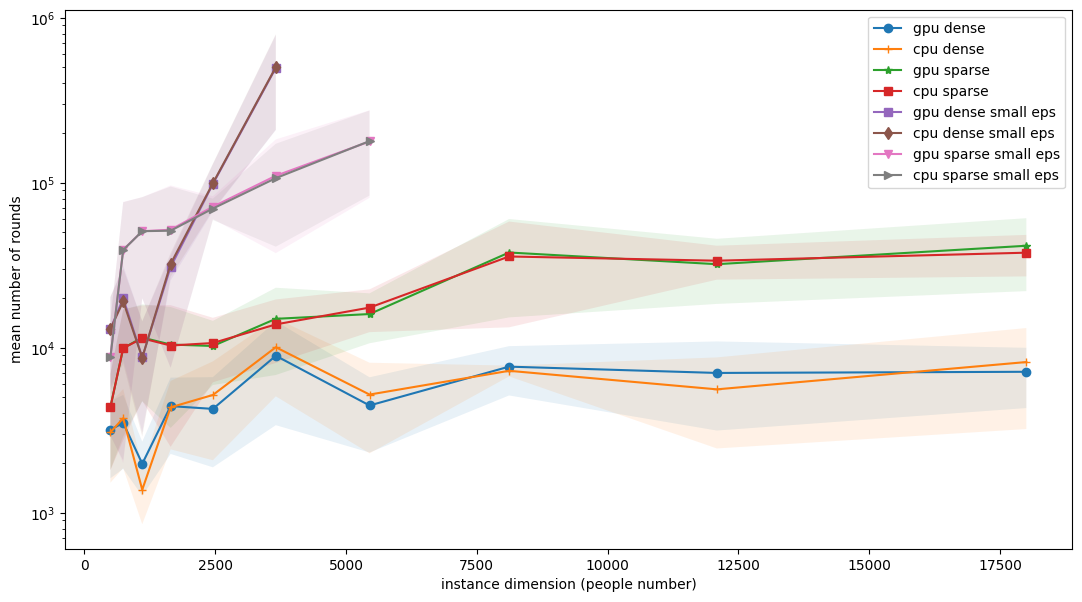

In [22]:
result_list=total_res[0]
j = 0
mean = result_list[0]['gpu_round_num_mean']
sd = result_list[0]['gpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='gpu dense')
plt.fill_between(result_list[0].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[0]['cpu_round_num_mean']
sd = result_list[0]['cpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='cpu dense')
plt.fill_between(result_list[0].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[1]['gpu_round_num_mean']
sd = result_list[1]['gpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label = 'gpu sparse')
plt.fill_between(result_list[1].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[1]['cpu_round_num_mean']
sd = result_list[1]['cpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='cpu sparse')
plt.fill_between(result_list[1].index,mean-sd,mean+sd,alpha=.1)



result_list=result_small_eps_list

mean = result_list[0]['gpu_round_num_mean']
sd = result_list[0]['gpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='gpu dense small eps')
plt.fill_between(result_list[0].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[0]['cpu_round_num_mean']
sd = result_list[0]['cpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='cpu dense small eps')
plt.fill_between(result_list[0].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[1]['gpu_round_num_mean']
sd = result_list[1]['gpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label = 'gpu sparse small eps')
plt.fill_between(result_list[1].index,mean-sd,mean+sd,alpha=.1)
j+=1
mean = result_list[1]['cpu_round_num_mean']
sd = result_list[1]['cpu_round_num_sd']
plt.plot(mean, '-'+markers[j],label='cpu sparse small eps')
plt.fill_between(result_list[1].index,mean-sd,mean+sd,alpha=.1)


plt.xlabel("instance dimension (people number)")
plt.ylabel("mean number of rounds")
plt.legend(loc="upper right")

plt.yscale('log')

Text(0, 0.5, 'number of active bidders')

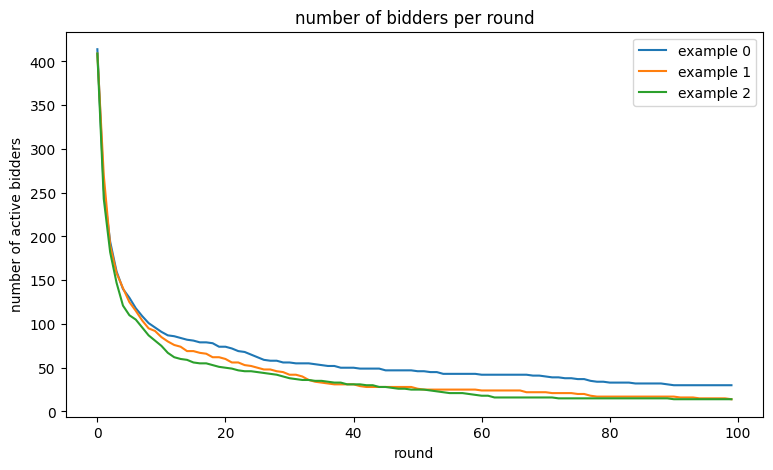

In [23]:
plt.rcParams["figure.figsize"] = (9,5)
fns = [
    AUX_FOLDER + 'unmatched_log_1108_007.txt',
    AUX_FOLDER + 'unmatched_log_1108_008.txt',
    AUX_FOLDER + 'unmatched_log_1108_009.txt',
    ]
for i,fn in enumerate(fns):
    data = []
    with open(fn,'r') as f:
        for line in f:
            if line.startswith('unmatched'):
                data.append(int(line.split(' ')[1]))
    plt.plot(data[:100], label='example '+str(i)) # limit to the first 100 iterations
plt.legend(loc="upper right")
plt.title('number of bidders per round')
plt.xlabel('round')
plt.ylabel('number of active bidders')